## Examples for demonstrating different classification techniques

In [8]:
%matplotlib widget

import numpy as np
import xarray as xa
import matplotlib.pyplot as plt
from skimage import exposure # We are going to rescale the image
import sklearn as skl
from sklearn.cluster import KMeans # Unsupervised learning
from sklearn.neural_network import MLPClassifier # Supervised learning
from matplotlib.colors import ListedColormap # For colourmap
from matplotlib import patches

We have now imported some libraries and will load some Sentinel 1 OpenDAP NetCDF
data from https://satellittdata.no

In [9]:
url = 'https://nbstds.met.no/thredds/dodsC/NBS/S2A/2025/09/30/S2A_MSIL2A_20250930T104041_N0511_R008_T33WWR_20250930T124013.nc'
dset = xa.open_dataset(url+'#fillmismatch') # opening OpenDAP NetCDF dataset

Having opened the dataset we can how have a look at the header

In [10]:
print(dset)

<xarray.Dataset> Size: 8GB
Dimensions:         (raster_band_id: 13, time: 1, ya: 22, xa: 22, orbit_dim: 3,
                     y: 10980, x: 10980)
Coordinates:
  * time            (time) datetime64[ns] 8B 2025-09-30T10:40:41
  * y               (y) int32 44kB 7600020 7600010 7600000 ... 7490240 7490230
  * x               (x) int32 44kB 499980 499990 500000 ... 609750 609760 609770
Dimensions without coordinates: raster_band_id, ya, xa, orbit_dim
Data variables: (12/24)
    band_id         (raster_band_id) int32 52B ...
    UTM_projection  int32 4B ...
    view_azimuth    (time, raster_band_id, ya, xa) float32 25kB ...
    view_zenith     (time, raster_band_id, ya, xa) float32 25kB ...
    sun_zenith      (time, ya, xa) float32 2kB ...
    sun_azimuth     (time, ya, xa) float32 2kB ...
    ...              ...
    B9              (time, y, x) float32 482MB ...
    MSK_CLDPRB      (time, y, x) float32 482MB ...
    MSK_SNWPRB      (time, y, x) float32 482MB ...
    AOT             (tim

Notice that it contains coordinates, variables, and attributes. We can for
instance take a closer look at the time coordinate

In [17]:
print(dset.x)

<xarray.DataArray 'x' (x: 10980)> Size: 44kB
array([499980, 499990, 500000, ..., 609750, 609760, 609770],
      shape=(10980,), dtype=int32)
Coordinates:
  * x        (x) int32 44kB 499980 499990 500000 500010 ... 609750 609760 609770
Attributes:
    units:          m
    standard_name:  projection_x_coordinate
    _ChunkSizes:    10980


and the B2 data variable

In [12]:
print(dset.B2)

<xarray.DataArray 'B2' (time: 1, y: 10980, x: 10980)> Size: 482MB
[120560400 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 8B 2025-09-30T10:40:41
  * y        (y) int32 44kB 7600020 7600010 7600000 ... 7490250 7490240 7490230
  * x        (x) int32 44kB 499980 499990 500000 500010 ... 609750 609760 609770
Attributes:
    units:                  1
    grid_mapping:           UTM_projection
    standard_name:          surface_bidirectional_reflectance
    long_name:              Reflectance in band B2
    bandwidth:              65
    bandwidth_unit:         nm
    wavelength:             490
    wavelength_unit:        nm
    solar_irradiance:       1959.66
    solar_irradiance_unit:  W/m2/um
    _ChunkSizes:            [   1 2745 2745]


**What is B2?**

We can plot B2 to see it better

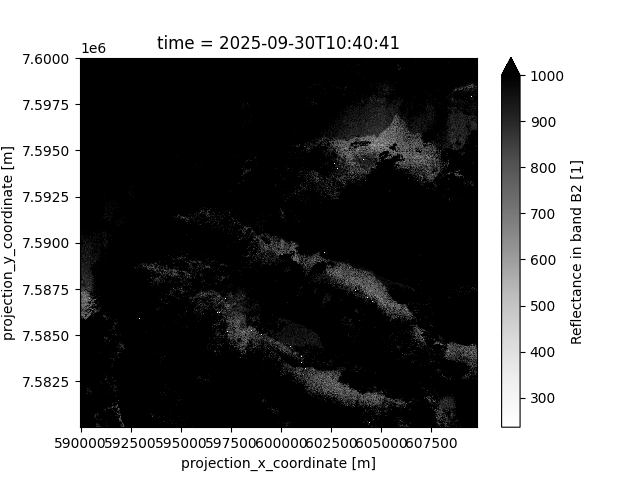

In [13]:
# East - west
xmin = 9000
xmax = -1

# North - south
ymin = 0
ymax = 2000

plt.figure()
view =dset.B2[0,ymin:ymax,xmin:xmax]
view.plot(cmap='Greys',vmax=1000)
plt.show()



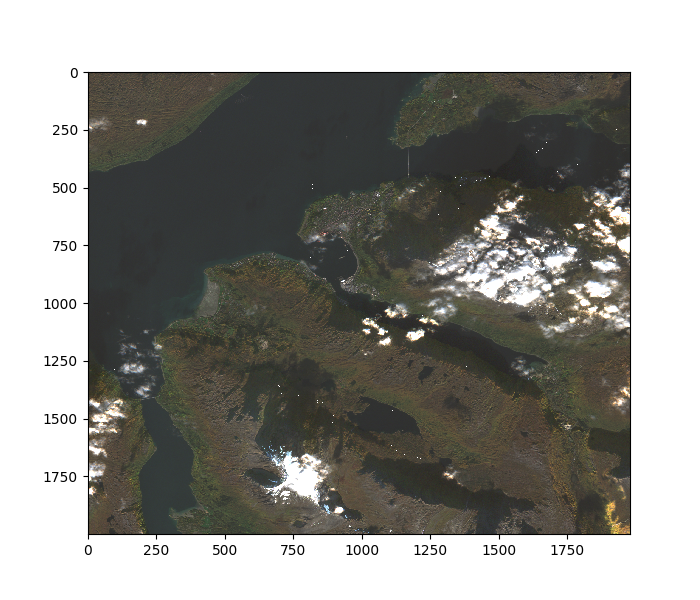

In [31]:
#extent = np.asarray(
#            [dset.lon[ymin,xmin].data, dset.lon[ymin,xmax].data,
#            dset.lat[ymax,xmax].data, dset.lat[ymin,xmin].data]
#         ) # To get the axis labels correct we define an extent

#print('lon and lat',(extent)) # These are the latitudes and longitudes
n=0
# Reading in some parts of the r b g bands
b = dset.B2[n,ymin:ymax,xmin:xmax]/float(dset.attrs['BOA_QUANTIFICATION_VALUE'])
g = dset.B3[n,ymin:ymax,xmin:xmax]/float(dset.attrs['BOA_QUANTIFICATION_VALUE'])
r = dset.B4[n,ymin:ymax,xmin:xmax]/float(dset.attrs['BOA_QUANTIFICATION_VALUE'])

P0, P1 = (0, 0.5) # These are the percentages we are going to rescale on 

# Rescaling the exposures using scikit-image 
r = exposure.rescale_intensity(r,in_range=(P0,P1))
g = exposure.rescale_intensity(g,in_range=(P0,P1))
b = exposure.rescale_intensity(b,in_range=(P0,P1))

# Making the RGB image
rgb = np.dstack((r,g,b))

# Clipping it
rgb[rgb>1]=1.0


# Plotting the RGB image
plt.figure(figsize=(7,6))
plt.imshow(rgb, interpolation='none', aspect='auto')
plt.show()

### Normalized difference vegetation index (NDVI)
Is a measure for how much vegitation there is in a pixel. More information can be found in the book (10.6), 
https://custom-scripts.sentinel-hub.com/sentinel-2/ndvi/
and
https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index

It is given by:
$\text{NDVI} = \frac{\textrm{NIR}-\textrm{RED}}{\textrm{NIR}+\textrm{RED}}$

which for Sentinel-2 becomes:

$\text{NDVI} = \frac{\textrm{B8}-\textrm{B4}}{\textrm{B8}+\textrm{B4}}$

We are now going to test it, though we are using L1C data. Normally one would use L2A

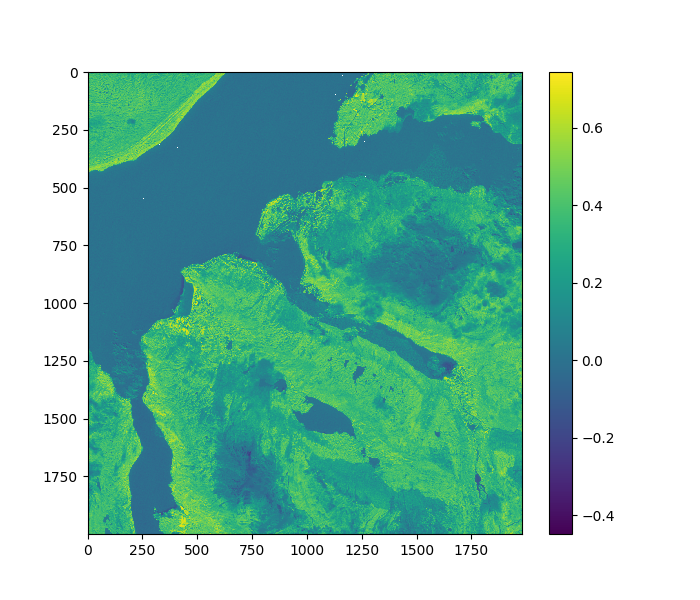

In [33]:
ndvi = (dset.B8[n,ymin:ymax,xmin:xmax] -dset.B4[n,ymin:ymax,xmin:xmax])/(dset.B8[n,ymin:ymax,xmin:xmax] +dset.B4[n,ymin:ymax,xmin:xmax])
plt.figure(figsize=(7,6))
plt.imshow(ndvi, interpolation='none', aspect='auto')#, extent = extent)
plt.colorbar()
plt.show()

### Normalized difference water index (NDWI)
Measures how much water there is in the pixel as part of a water body.  More information can be found at:
https://custom-scripts.sentinel-hub.com/sentinel-2/ndwi/
og 
https://en.wikipedia.org/wiki/Normalized_difference_water_index


It is given by:
$\text{NDWI} = \frac{\textrm{GREEN}-\textrm{NIR}}{\textrm{GREEN}+\textrm{NIR}}$


which for Sentinel-2 becomes:

$\text{NDWI} = \frac{\textrm{B3}-\textrm{B8}}{\textrm{B3}+\textrm{B8}}$

We are now going to test it, though we are using L1C data. Normally one would use L2A

In [ ]:
ndwi = (dset.B3[n,ymin:ymax,xmin:xmax] -dset.B8[n,ymin:ymax,xmin:xmax])/(dset.B3[n,ymin:ymax,xmin:xmax] +dset.B8[n,ymin:ymax,xmin:xmax])
plt.figure(figsize=(7,6))
plt.imshow(ndwi, interpolation='none', aspect='auto', extent = extent)
plt.colorbar()
plt.show()

### Unsupervised learning

This is learning where we as the computer to classify the area based on a given model. In this case we are going to use [scikit-learn](https://scikit-learn.org/stable/)
and the method [K-means](https://scikit-learn.org/stable/modules/clustering.html#k-means) to cluster data. It is based on the minimising the variance in the cluster, though something called its intertia. The link above has an excellent explanation.




(3958000, 4)
(3958000,)


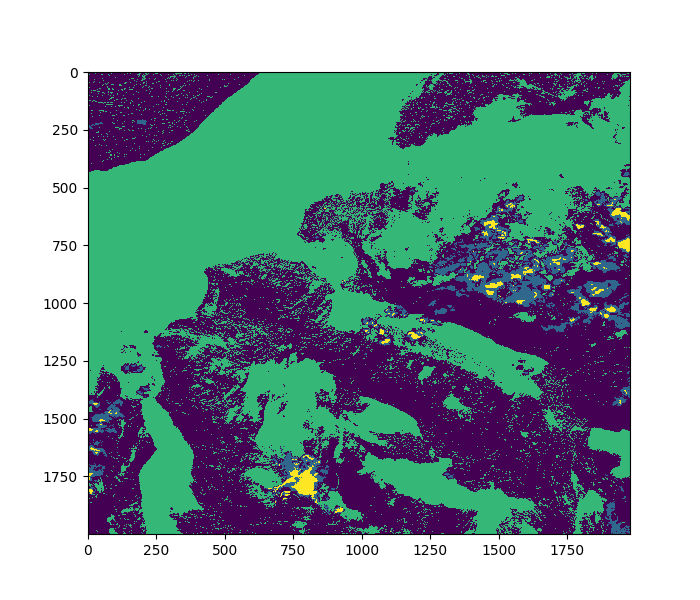

In [37]:
  # We are first going to make the dataset, which here is going to be rgb + NIR

rgbn = np.dstack((dset.B4[n,ymin:ymax,xmin:xmax],dset.B3[n,ymin:ymax,xmin:xmax],
      dset.B2[n,ymin:ymax,xmin:xmax],dset.B8[n,ymin:ymax,xmin:xmax]))

w, h, d = original_shape = tuple(rgbn.shape)

rgbn_2d = np.reshape(rgbn,(w*h,d))
print(rgbn_2d.shape)
rgbn_2d[np.isnan(rgbn_2d)]=0
# We select a small subset to fit on:
rgbn_sample = skl.utils.shuffle(rgbn_2d, random_state=0, n_samples=1_000)

# We are now going to ask for a certain number of clusters
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rgbn_sample)

# Predict the labels for the whole image 
# (this could also be a new image, and can be reused on multiple images)

labels = kmeans.predict(rgbn_2d)
print(labels.shape)

# Show the results
plt.figure(figsize=(7,6))
plt.imshow(labels.reshape(w,h), interpolation='none', aspect='auto')#, extent = extent)
plt.show()

### Supervised learning

In contrast to unsupervised learning, in supervised learning we need to teach the algorithm what a given class looks like. 
We have a range of different algorithms to choose from, and it would be to much to go through them all. 
Here we choose to use a neural network, specifically "Multi-layer Perceptron" from scikit-learn. You can read more about it at [Neural network models (supervised)](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)

There are much faster implmentations neural networks in deep learning architectures, but these require the use of GPUs and dedicated software (for instance [TensorFLow](https://www.tensorflow.org/) ). SNAP also has built in modules for supervised learning.



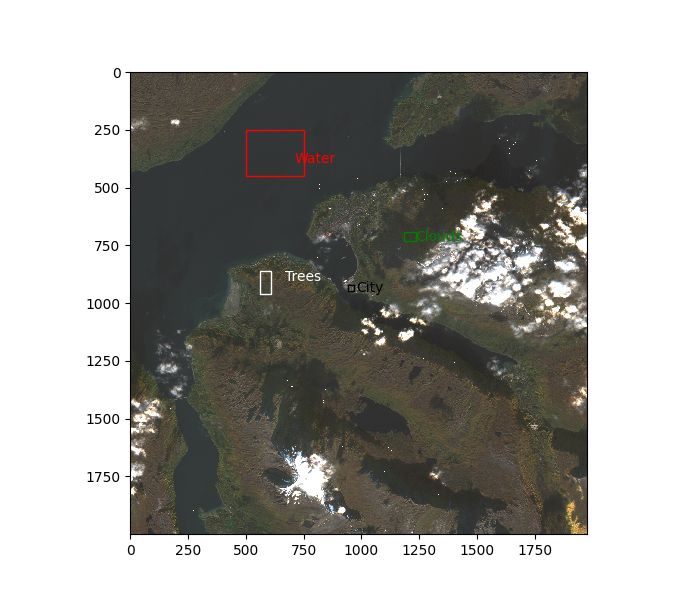

In [38]:
# We first need to define som areas to learn from. We are going to look at classifying into 
# four different types and we will be using the same dataset (rgbn) as for unsupervised classification

wx=[500, 700]
wy=[250, 500]

water = rgbn[wx[0]:wx[1],wy[0]:wy[1],:]
water = np.reshape(water,(water.shape[0]*water.shape[1],d)) # making it 2d

tx=[560, 660]
ty=[860, 910]

trees = rgbn[tx[0]:tx[1],ty[0]:ty[1],:]
trees = np.reshape(trees,(trees.shape[0]*trees.shape[1],d)) # making it 2d

cx=[1185, 1225]
cy=[690, 740]

clouds = rgbn[cx[0]:cx[1],cy[0]:cy[1],:]
clouds = np.reshape(clouds,(clouds.shape[0]*clouds.shape[1],d)) # making it 2d

bx=[943, 970]
by=[920, 945]

build = rgbn[bx[0]:bx[1],by[0]:by[1],:]
build = np.reshape(build,(build.shape[0]*build.shape[1],d)) # making it 2d



def plot_rect(xlim, ylim, text, col):
    ax = plt.gca() # get current axis
    ax.add_patch(patches.Rectangle((xlim[0], ylim[0]), ylim[1]-ylim[0], xlim[1]-xlim[0], edgecolor=col, fill=False))
    ax.annotate(text,(xlim[1]+10, ylim[0]+(ylim[1]-ylim[0])/2), color=col, ha='left', va='center')
    

# Show where the rectangles are
plt.figure(figsize=(7,6))
plt.imshow(rgb, interpolation='none', aspect='equal')#, extent = extent) # Plotting it in x y coordinates and not lat lon
plot_rect(wx, wy, "Water", "red")
plot_rect(tx, ty, "Trees", "white")
plot_rect(cx, cy, "Clouds", "green")
plot_rect(bx, by, "City", "black")
plt.show()


In [ ]:
# Now we are going to use these to train the algorithm
X = np.concatenate([water, trees, clouds, build])

#Assigning labels 0 = water, 1 = trees, 2 = clouds, 3 = city
y = np.concatenate([
    np.zeros(water.shape[0]),
    np.ones(trees.shape[0]),
    np.ones(clouds.shape[0]) + 1,
    np.ones(build.shape[0]) + 2])
# 
print(X.shape,y.shape)
# Initialise the neural network
clf = MLPClassifier() # We are using default values
clf.fit(X, y)

# How many layers and outputs are we using:
print(clf.n_layers_, clf.n_outputs_)

labels_nn = clf.predict(rgbn_2d)
print(labels_nn.shape)




In [ ]:

# Assigning colours to the different labels
col_dict={0:"blue", # Sea
          1:"green", # Trees
          2:"white", # Clouds
          3:"black"} # City


cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

plt.figure(figsize=(7,6))
plt.imshow(labels_nn.reshape(w,h), interpolation='none', aspect='equal', cmap=cm)#, extent = extent,cmap=cm)
cbar = plt.colorbar( orientation='horizontal',ticks=[3/8,2*3/4-3/8,3*3/4-3/8,4*3/4-3/8])
cbar.ax.set_xticklabels(['Sea', 'Trees', 'Clouds', 'Houses'])
plt.show()